In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from random import randint
import matplotlib.dates as mdates
import pickle

# Data loading

In [2]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)
medium_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,33701.0,1.680706e+09,3.419155e+06,1.674810e+09,1.677525e+09,1.680842e+09,1.683754e+09,1.686292e+09
availability,33693.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
avg_alloc_mem,33693.0,1.119697e+05,2.338880e+04,0.000000e+00,9.507000e+04,1.104274e+05,1.247022e+05,2.400000e+05
avg_allocated_cpus_per_job,33694.0,7.974380e+02,2.402666e+02,-1.000000e+00,6.380731e+02,7.728302e+02,9.134590e+02,2.880000e+03
avg_allocated_nodes_per_job,33694.0,3.114549e+00,9.402489e-01,-1.000000e+00,2.492473e+00,3.018868e+00,3.568199e+00,1.125000e+01
node_total,31781.0,1.298227e+03,1.312735e+02,3.000000e+00,1.290000e+03,1.355000e+03,1.366000e+03,1.379000e+03
avg_cpus_load_lower,33693.0,6.847435e+01,1.485700e+02,0.000000e+00,3.446333e+01,4.888500e+01,6.488833e+01,1.664107e+03
nodes,31781.0,1.298227e+03,1.312735e+02,3.000000e+00,1.290000e+03,1.355000e+03,1.366000e+03,1.379000e+03
avg_cpus_load_upper,33693.0,1.578772e+02,2.221920e+02,2.000000e-02,9.289455e+01,1.078240e+02,1.275860e+02,3.910001e+03
avg_execution_time_per_job,33694.0,5.320246e+04,1.303897e+04,-1.000000e+00,4.455893e+04,5.213659e+04,6.115107e+04,1.862302e+05


In [3]:
def handle_missing_data(df, frequency="5min"):
    return df.resample(frequency).interpolate()

def plot_df_feature(df, feature_name, x_initial=0, x_final=None):
    if x_final is None:
        x_final = len(df)
    y = df[feature_name][x_initial:x_final]
    x = df.index[x_initial:x_final]
    fig, ax = plt.subplots()
    ax.set_xlabel("Time")
    ax.set_ylabel(feature_name)
    fig.set_size_inches(15, 5)
    ax.plot(x, y)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

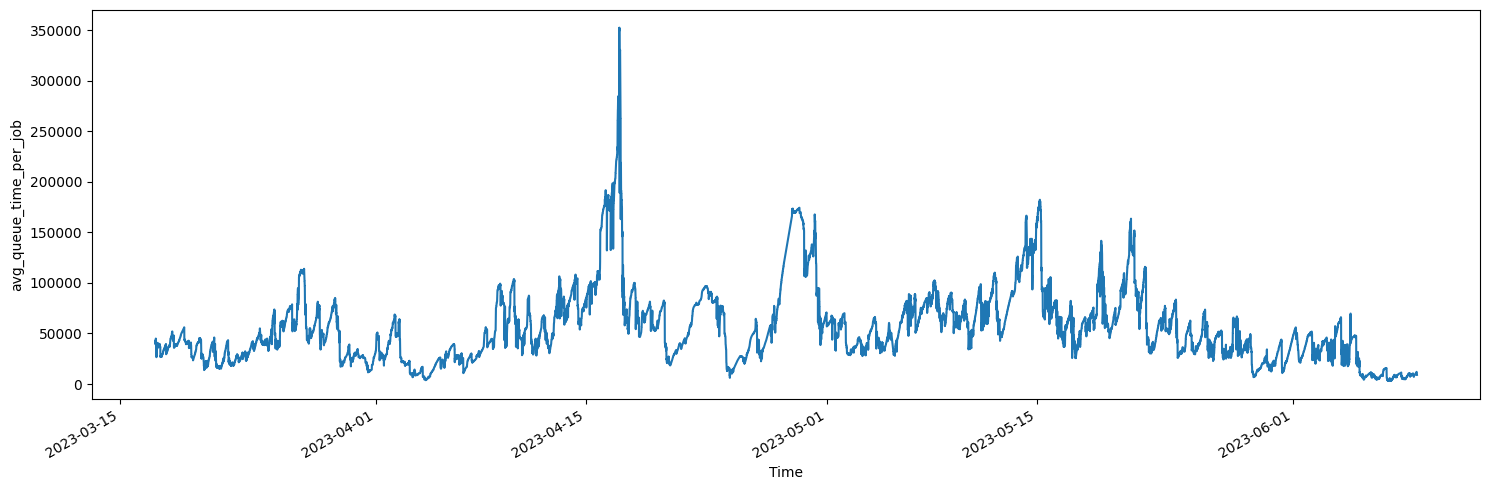

In [4]:

# Taking values in dataset after collection gap
medium_df_copy = medium_df.copy()

# 1- convert date to time index
medium_df_copy['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df_copy.set_index('date', inplace=True)
# 2- remove features with no variance
filter = medium_df_copy.std() == 0
features_to_drop = medium_df_copy.columns[filter]
medium_df_copy.drop(features_to_drop, axis=1, inplace=True)
# Sort time index
medium_df_copy.sort_index(inplace=True)
medium_df_copy.describe().transpose() 

# Filling gaps and resampling
avg_queue_time_series = medium_df_copy['avg_queue_time_per_job'][10900:]
dataset = avg_queue_time_series.to_frame()
dataset = handle_missing_data(dataset)

plot_df_feature(dataset, "avg_queue_time_per_job", x_initial=0, x_final=len(dataset))

In [6]:
medium_df_copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,33693.0,111969.734378,23388.804483,0.000000,95070.000000,110427.428571,124702.222222,240000.000000
avg_allocated_cpus_per_job,33694.0,797.438035,240.266644,-1.000000,638.073118,772.830189,913.459011,2880.000000
avg_allocated_nodes_per_job,33694.0,3.114549,0.940249,-1.000000,2.492473,3.018868,3.568199,11.250000
node_total,31781.0,1298.227306,131.273526,3.000000,1290.000000,1355.000000,1366.000000,1379.000000
avg_cpus_load_lower,33693.0,68.474353,148.569986,0.000000,34.463333,48.885000,64.888333,1664.106667
nodes,31781.0,1298.227306,131.273526,3.000000,1290.000000,1355.000000,1366.000000,1379.000000
avg_cpus_load_upper,33693.0,157.877202,222.191963,0.020000,92.894545,107.824000,127.586000,3910.001250
avg_execution_time_per_job,33694.0,53202.455023,13038.972711,-1.000000,44558.930233,52136.588047,61151.066390,186230.188144
avg_free_mem_lower,33693.0,186503.676521,18751.846716,7658.000000,178602.600000,189727.833333,198682.000000,246061.000000
avg_free_mem_upper,33693.0,235342.166431,7372.556242,160283.750000,231105.666667,236531.000000,240763.400000,249717.000000


# Data analysis

# Data processing

In [7]:
def prepare_time_series(data, target_col, past_observations_samples, future_sample=1, return_all_future_samples=False):
    X, y = [], []
    if isinstance(data, np.ndarray):
        aux = data[:,0]
        data = pd.DataFrame()
        data[target_col] = aux
    for i in range(data.shape[0]-past_observations_samples-future_sample+1):
        # print(i)
        x_index = i+past_observations_samples
        y_index = x_index+future_sample-1
        if future_sample > 1 and return_all_future_samples==False:
            seq_y = data[target_col].iloc[y_index]
        else:
            seq_y = data[target_col].iloc[x_index:y_index+1]
        seq_x = data[target_col].iloc[i:x_index]
        
        X.append(seq_x)
        y.append(seq_y)
    final_X = np.array(X).reshape(len(X), past_observations_samples, 1)
    final_y = np.array(y)
    return final_X, final_y

def resample_data(data, target_columns, datetime_column, resample_period):
    data['datetime_sample'] = pd.to_datetime(data[datetime_column], unit="s")
    resample_data = data.resample(resample_period, on='datetime_sample').power.mean()
    return resample_data

def scale_data(data, col):
    scaler = MinMaxScaler()
    norm_data = scaler.fit_transform(data[col].values.reshape(-1,1))
    return norm_data, scaler

def preprocessing_step(data, target_col, past_observations_samples, future_sample=1, 
                       do_scale_data=True, test_size=0.2,
                       return_tensors=True, return_all_future_samples=False):
    
    # 1- Normalize the data
    # 2- Create time series
    preprocessed_data = data.copy()
         
    if do_scale_data==True:
        scaled_data, scaler = scale_data(data=data, col=target_col)
        preprocessed_data[target_col] = scaled_data
    
    train_size = int(len(scaled_data) * (1-test_size))
    train, test = preprocessed_data.iloc[0:train_size,:], preprocessed_data.iloc[train_size:len(scaled_data),:]
    test.reset_index(inplace=True, drop=True)
    
    x_train, y_train = prepare_time_series(train, target_col=target_col, 
                                           past_observations_samples=past_observations_samples, 
                                           future_sample=future_sample, 
                                           return_all_future_samples=return_all_future_samples)
    x_test, y_test = prepare_time_series(test, target_col=target_col, 
                                         past_observations_samples=past_observations_samples, 
                                         future_sample=future_sample, 
                                         return_all_future_samples=return_all_future_samples)
    
    if return_tensors == True:
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train)
        x_test = torch.Tensor(x_test)
        y_test = torch.Tensor(y_test)
       
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
        
    
    print('X Train subset shape: ',x_train.shape)
    print('Y Train subset shape: ', y_train.shape)
    print('X Test subset shape: ',x_test.shape)
    print('Y Test subset shape: ', y_test.shape)
    
    return {'scaled_data': preprocessed_data,
            'x_train':x_train,
            'y_train':y_train,
            'x_test':x_test,
            'y_test':y_test,
            'scaler':scaler}


class SequenceDataset(Dataset):
    def __init__(self, data, target_col, past_observations_samples, future_sample=1,
                 do_scale_data=True, test_size=0, return_tensors=True, 
                 return_all_future_samples=False, is_train=True):
        
        series_dict = preprocessing_step(data, target_col=target_col, 
                                         past_observations_samples=past_observations_samples,
                                         future_sample=future_sample,
                                         test_size=test_size,
                                         do_scale_data=do_scale_data, return_tensors=return_tensors,
                                         return_all_future_samples = return_all_future_samples)
        if is_train == True:
            self.X = series_dict['x_train']
            self.y = series_dict['y_train']
        else:
            self.X = series_dict['x_test']
            self.y = series_dict['y_test']
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [8]:
an_hour = int(60/5) # samples every 5 min
a_day = int(24 * an_hour)
past_observations_samples = a_day
future_sample = an_hour
return_tensors=True
return_all_future_samples = False
test_size = 0.2
do_scale_data = True

train_dataset = SequenceDataset(dataset, target_col="avg_queue_time_per_job", is_train=True,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

test_dataset = SequenceDataset(dataset, target_col="avg_queue_time_per_job", is_train=False,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

series_dict = preprocessing_step(dataset, target_col="avg_queue_time_per_job", 
                                 past_observations_samples=past_observations_samples, 
                                 future_sample=future_sample,
                                 test_size=test_size,
                                 do_scale_data=do_scale_data, return_tensors=return_tensors,
                                 return_all_future_samples = return_all_future_samples)

X Train subset shape:  torch.Size([19042, 288, 1])
Y Train subset shape:  torch.Size([19042])
X Test subset shape:  torch.Size([4537, 288, 1])
Y Test subset shape:  torch.Size([4537])


KeyboardInterrupt: 

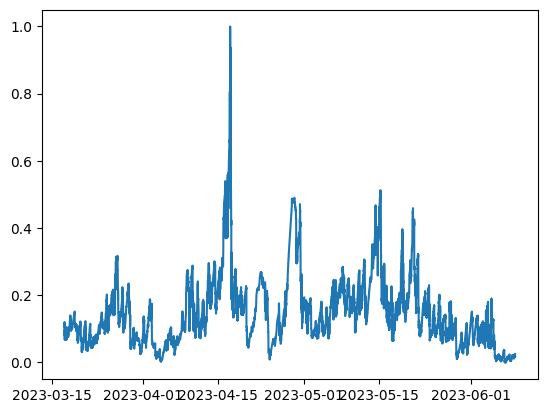

In [8]:
plt.plot(series_dict['scaled_data']['avg_queue_time_per_job'])

# Data forecasting

## Architecture Definition

In [7]:
def compute_loss(criterion, labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        return criterion(model_outputs, torch.Tensor(labels.reshape([-1,1])))
    return criterion(model_outputs, torch.Tensor(labels.squeeze()))

def compute_residuals(labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        res = model_outputs-torch.Tensor(labels.reshape([-1,1]))
        return res.detach().numpy()
    res = model_outputs-torch.Tensor(labels.squeeze())
    return res.detach().numpy()

def run_train(model, optimizer, train_dataloader, test_dataloader, num_epochs, num_train_batches, criterion):
    residuals = None
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            # if i % 50 == 0:
            #     print(f"Batch: {i+1} out of {num_train_batches}")
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 2 == 0:
            val_loss, _residuals = run_test(model=model, test_dataloader=test_dataloader, criterion=criterion)
            if residuals is None:
                residuals = _residuals
            else:
                residuals = np.concatenate((residuals, _residuals))
            print("Epoch: %d. Training loss: %1.5f. Validation loss: %1.5f." % (epoch, epoch_loss/num_train_batches, val_loss))
    return epoch_loss/num_train_batches, val_loss, residuals
    
def run_test(model, test_dataloader, criterion):
    val_loss = 0
    residuals = None
    for i, (inputs, labels) in enumerate(test_dataloader):
        #print(inputs.shape)
        outputs = model(inputs)
        loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
        if residuals is None:
            residuals = compute_residuals(labels=labels, model_outputs=outputs)
        else:
            residuals = np.concatenate((residuals, compute_residuals(labels=labels, model_outputs=outputs)))
        val_loss += loss.item()
    return val_loss/len(test_dataloader), residuals

class forecasting_model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim:list=None, n_layers:list=None, dropout=0.2, 
                 output_size=1, bias=True, bidirectional=False, fc_outputs:list=None):
        super(forecasting_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.fc_outputs = fc_outputs
        
        self.initialize_values()
        
        self.gru_layer_1 = nn.GRU(input_size = input_dim,
                               hidden_size=self.hidden_dim[0],
                               num_layers=self.n_layers[0],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_1 = nn.Dropout(dropout)
        self.gru_layer_2 = nn.GRU(input_size = self.hidden_dim[0],
                               hidden_size=self.hidden_dim[1],
                               num_layers=self.n_layers[1],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_2 = nn.Dropout(dropout)
        self.fc_layer_1 = nn.Linear(self.hidden_dim[1], self.fc_outputs[0])
        self.dropout_layer_3 = nn.Dropout(dropout)
        self.fc_layer_2 = nn.Linear(self.fc_outputs[0], self.fc_outputs[1])
        self.dropout_layer_4 = nn.Dropout(dropout)
        self.output_layer = nn.Linear(self.fc_outputs[1], output_size)
    
    def initialize_values(self):
        if self.hidden_dim == None or len(self.hidden_dim) < 2:
            self.hidden_dim = [128, 64]
        if self.n_layers == None or len(self.n_layers) < 2:
            self.n_layers = [1, 1]
        if self.fc_outputs == None or len(self.fc_outputs) < 2:
            self.fc_outputs = [128, 64]
        
    
    def forward(self, x):
        
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        
        h0 = torch.zeros(self.n_layers[0], torch.Tensor(x).size(0), self.hidden_dim[0])
        h1 = torch.zeros(self.n_layers[1], torch.Tensor(x).size(0), self.hidden_dim[1])
        
        out, hidden_states = self.gru_layer_1(x, h0.detach())
        out = self.dropout_layer_1(out)
        out, hidden_states = self.gru_layer_2(out, h1.detach())
        out = self.dropout_layer_2(out)
        out = out[:, -1, :]
        out = self.fc_layer_1(out)
        out = self.dropout_layer_3(out)
        out = self.fc_layer_2(out)
        out = self.dropout_layer_4(out)
        out = self.output_layer(out)
        return out

In [8]:
num_epochs = 100
learning_rate = 0.01
hidden_size = [256,128]
num_layers = 2
dropout=0.05
batch_size = 128
input_size = 1
    
if return_all_future_samples == False:
    output_size = 1
else:
    output_size=future_sample

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_train_batches = len(train_dataloader)

model = forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)

print(f'Model architecture: \n{model}')

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print('Start training')
training_loss, validation_loss, residuals = run_train(
    model=model, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader, 
    num_epochs=num_epochs, num_train_batches=num_train_batches, criterion=criterion)

Model architecture: 
forecasting_model(
  (gru_layer_1): GRU(1, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Start training
Batch: 1 out of 149
Batch: 51 out of 149
Batch: 101 out of 149
Epoch: 0. Training loss: 0.11664. Validation loss: 0.03833.
Batch: 1 out of 149
Batch: 51 out of 149
Batch: 101 out of 149
Batch: 1 out of 149
Batch: 51 out of 149
Batch: 101 out of 149
Epoch: 2. Training loss: 0.01302. Validation loss: 0.02963.
Batch: 1 out of 149
Batch: 51 out of 149
Batch: 101 out of 149
Batch: 1 out of 149
Batch: 51 out of 149
Batch: 101 out of 149

In [9]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Save train model
torch.save(model.state_dict(), "model.pth")

# Save residuals
with open('residuals.obj', 'wb') as residuals_file:
    pickle.dump(residuals, residuals_file)



Model's state_dict:
gru_layer_1.weight_ih_l0 	 torch.Size([768, 1])
gru_layer_1.weight_hh_l0 	 torch.Size([768, 256])
gru_layer_1.bias_ih_l0 	 torch.Size([768])
gru_layer_1.bias_hh_l0 	 torch.Size([768])
gru_layer_2.weight_ih_l0 	 torch.Size([384, 256])
gru_layer_2.weight_hh_l0 	 torch.Size([384, 128])
gru_layer_2.bias_ih_l0 	 torch.Size([384])
gru_layer_2.bias_hh_l0 	 torch.Size([384])
fc_layer_1.weight 	 torch.Size([128, 128])
fc_layer_1.bias 	 torch.Size([128])
fc_layer_2.weight 	 torch.Size([64, 128])
fc_layer_2.bias 	 torch.Size([64])
output_layer.weight 	 torch.Size([1, 64])
output_layer.bias 	 torch.Size([1])


In [14]:
#Load model
hidden_size = [256,128]
input_size = 1
dropout=0.05
if return_all_future_samples == False:
    output_size = 1
else:
    output_size=future_sample
model = forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)

forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)
model.load_state_dict(torch.load("model.pth"))
model.eval()

# Load residuals
residuals = None
with open('residuals.obj', 'rb') as residuals_file:
   residuals = pickle.load(residuals_file)

residuals

array([[0.12547067],
       [0.15699899],
       [0.15777314],
       ...,
       [0.15759045],
       [0.15794876],
       [0.14345348]], dtype=float32)

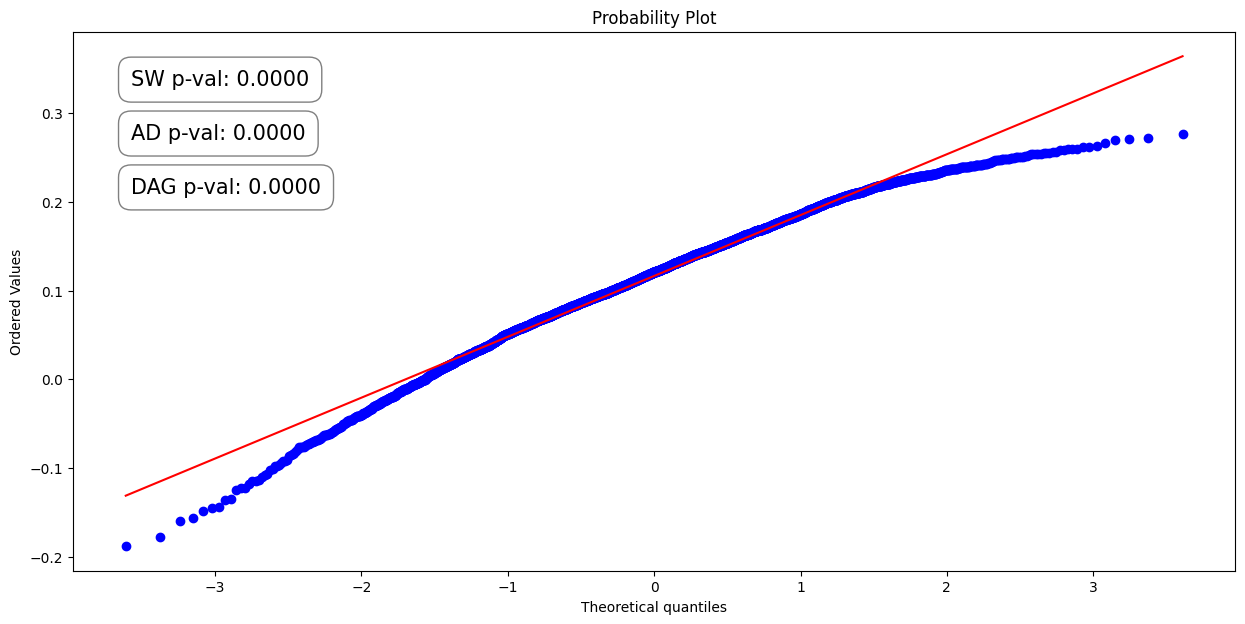

In [19]:
# Checking the normal distribution of residuals
# Required to compute the confidence intervale. 
# Test are showing residuals are not normally distributed so the condidence interval cannot be determined.
# Fixme during the trainig process, only the last epoch residuals are returned and not the complete set
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad

sw_result = stats.shapiro(residuals)
ad_result = normal_ad(residuals, axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals.reshape(-1,), plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"AD p-val: {ad_result[1][0]:.4f}", xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"DAG p-val: {dag_result[1][0]:.4f}", xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [70]:
def get_z_score(CI_level=0.95):
    if CI_level == 0.90:
        return 1.645
    if CI_level == 0.95:
        return 1.96
    if CI_level == 0.99:
        return 2.579
    return 1.96

def get_rmse(residuals):
    return np.sqrt(sum([x**2 for x in residuals]) / len(residuals))


def plot_with_ci(actual_data, predictions, col_label, time_axis, residuals, scaler, ci=0.95):
    actual_data = actual_data.reshape(-1,1)
    scaled_actual_data = actual_data
    predictions = scaler.inverse_transform(predictions.detach().numpy())
    actual_data = scaler.inverse_transform(actual_data.reshape(-1,1))
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(time_axis[0:actual_data.shape[0]], actual_data, color='#fc7d0b', label='Actual')    
    # ax.scatter(time_axis[0:actual_data.shape[0]],predictions)
    ax.plot(time_axis[0:actual_data.shape[0]],predictions)
    
    if ci is not None:
        band_size = get_rmse(residuals)*get_z_score(ci)
        min_margin = scaled_actual_data-band_size
        max_margin = scaled_actual_data+band_size
        max_margin = scaler.inverse_transform(max_margin.reshape(-1,1))
        min_margin = scaler.inverse_transform(min_margin.reshape(-1,1))
        ax.fill_between(time_axis[0:actual_data.shape[0]], min_margin.reshape(-1,), max_margin.reshape(-1,), color='b', alpha=.1)
        title = "Forecasting with "+str(ci*100) + '% Confidence'
    else:
        title = "Forecasting"
    
    
    ax.annotate("Validation subset", xy=(0.85,0.95),xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.legend(['Actual Data', 'Predictions', 'Confidence Interval'], loc='lower left')
    
    ax.set_title(title)
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M') # define the formatting
    
    ax.set_xlabel('Date (y-m-d H:M)')
    ax.set_ylabel(col_label)
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.xticks(rotation=45, fontweight='light',  fontsize='medium',)
    plt.show()

In [10]:
print(model)

forecasting_model(
  (gru_layer_1): GRU(1, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
a_week = a_day * 7
real_data = series_dict['scaled_data']['avg_queue_time_per_job'].values[-a_week:].reshape(-1, 1)
X, y = prepare_time_series(real_data, 
                           target_col='avg_queue_time_per_job',
                           past_observations_samples=past_observations_samples,
                           future_sample=future_sample)

time_axis = series_dict['scaled_data'][-a_week:].index

predictions = model(X)


In [ ]:
# predictions = []
# index = 0
# for input_features in X:
#   index += 1
#   print (index)
#   predictions.append(model(input_features.reshape(1, -1, 1))[0])
# predictions

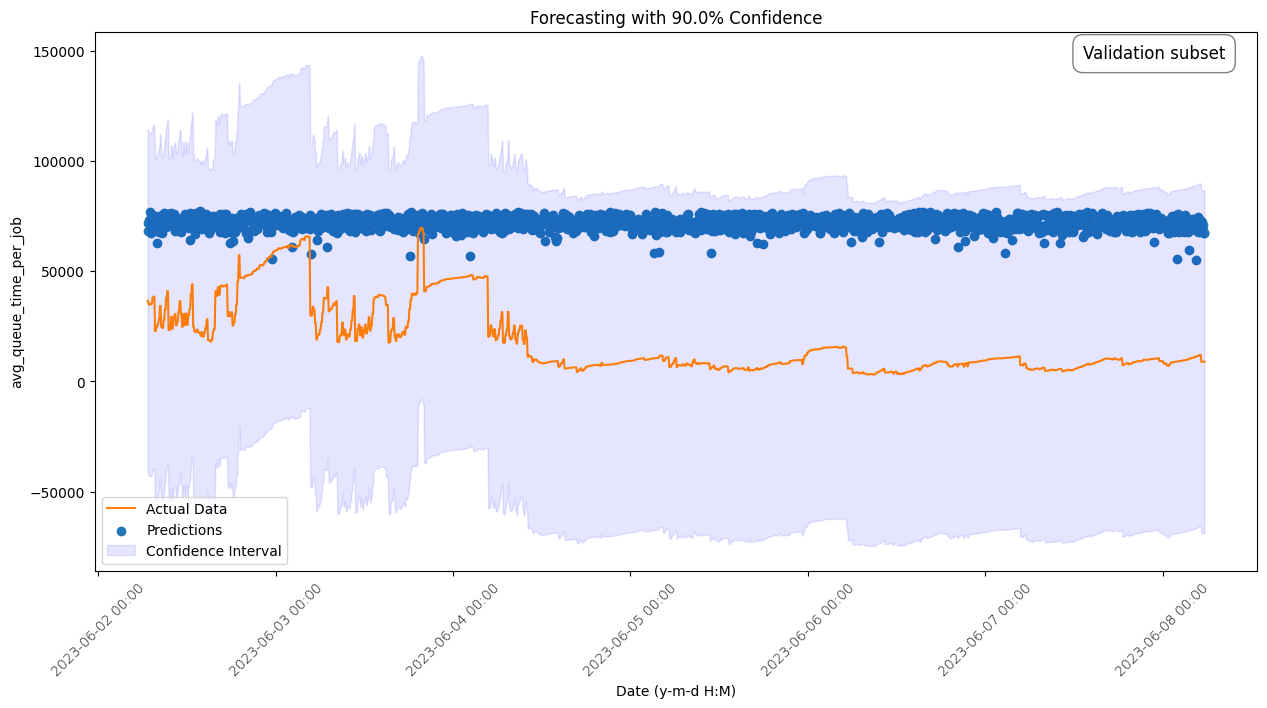

In [17]:
plot_with_ci(y, predictions, 'avg_queue_time_per_job', time_axis, residuals, series_dict['scaler'], ci=0.90)

TODO: 
- Investigate multivariate forecasting, using features correlated to target one
- Investigate overfitting - reduce model complexity


# Multivariate forecasting
Using multiple correlated feature for prediction

In [5]:
#Remove NaN gap
dataset = medium_df_copy[10900:]

# Drop features with low variance
def determine_dropped_colums(df: pd.core.frame.DataFrame, df_selected: np.ndarray):
    original_columns = df.columns
    dropped_columns = []
    index = -1
    for value in df.iloc[0]:
        index += 1
        if value not in df_selected[0]:
            dropped_columns.append(original_columns[index])
    return dropped_columns

from sklearn.feature_selection import VarianceThreshold
dataset_selected = VarianceThreshold(threshold=1.0).fit_transform(dataset)
dropped_columns = determine_dropped_colums(dataset, dataset_selected)
old_columns = dataset.columns
new_columns = old_columns.drop(dropped_columns)
dataset_selected = pd.DataFrame(dataset_selected, columns=new_columns, index=dataset.index)
dataset_selected.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,22801.0,115335.234491,23641.637316,0.000000,98509.333333,113813.333333,129680.000000,240000.000000
avg_allocated_cpus_per_job,22801.0,780.385665,189.466170,-1.000000,636.198020,768.680851,910.222222,1884.279070
node_total,22801.0,1276.586553,146.432045,98.000000,1274.000000,1345.000000,1360.000000,1374.000000
avg_cpus_load_lower,22801.0,44.868354,23.627639,0.000000,32.173333,43.303333,56.612000,599.620000
nodes,22801.0,1276.586553,146.432045,98.000000,1274.000000,1345.000000,1360.000000,1374.000000
avg_cpus_load_upper,22801.0,123.085212,103.733110,0.020000,88.265000,101.586000,119.145000,1491.630000
avg_execution_time_per_job,22801.0,53589.473944,12846.097857,-1.000000,45200.322222,52524.184290,61359.373494,186230.188144
avg_free_mem_lower,22801.0,185369.271721,18562.085310,52714.000000,177581.571429,188811.500000,197471.714286,246061.000000
avg_free_mem_upper,22801.0,236075.002701,7307.008053,160283.750000,232281.000000,237613.250000,241248.714286,249717.000000
avg_maximum_allocated_cpus_per_job,22801.0,653.561064,154.331199,308.592593,538.267218,634.122449,757.718876,1784.615385


[Text(0, 0, 'avg_alloc_mem'),
 Text(0, 1, 'avg_allocated_cpus_per_job'),
 Text(0, 2, 'node_total'),
 Text(0, 3, 'avg_cpus_load_lower'),
 Text(0, 4, 'nodes'),
 Text(0, 5, 'avg_cpus_load_upper'),
 Text(0, 6, 'avg_execution_time_per_job'),
 Text(0, 7, 'avg_free_mem_lower'),
 Text(0, 8, 'avg_free_mem_upper'),
 Text(0, 9, 'avg_maximum_allocated_cpus_per_job'),
 Text(0, 10, 'avg_minimum_requested_cpus_per_job'),
 Text(0, 11, 'avg_minimum_requested_memory_per_job'),
 Text(0, 12, 'avg_minimum_requested_nodes_per_job'),
 Text(0, 13, 'avg_pending_jobs'),
 Text(0, 14, 'node_alloc'),
 Text(0, 15, 'avg_queue_time_per_job'),
 Text(0, 16, 'node_idle'),
 Text(0, 17, 'avg_requested_cpus_per_job'),
 Text(0, 18, 'avg_running_jobs'),
 Text(0, 19, 'avg_time_left_per_job')]

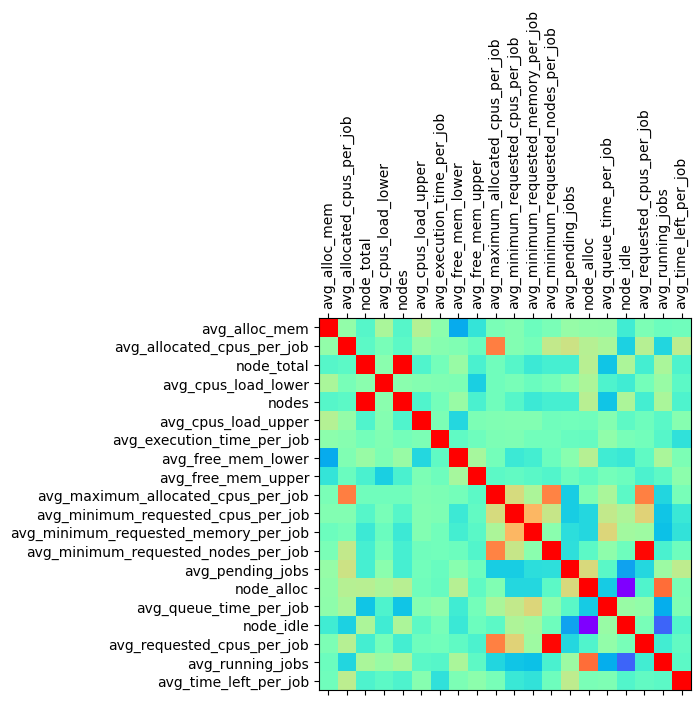

In [6]:
# Compute correlation matrix
features = dataset_selected.columns
cov_data = np.corrcoef(dataset_selected.T)
img = plt.matshow(cov_data, cmap=plt.cm.rainbow)
#plt.xticks(rotation=90)
#fig.autofmt_xdate(rotation=45)
xaxis = np.arange(len(features))
img.axes.set_xticks(xaxis)
img.axes.set_yticks(xaxis)
img.axes.set_xticklabels(features, rotation = 90)
img.axes.set_yticklabels(features)

In [7]:
def index_feature(features, feature):
    return features.get_loc(feature)
    
# Selected most correlated features (>0.3)
index = index_feature(features, "avg_queue_time_per_job")
condition = np.abs(cov_data[index]) > 0.3
selected_features = features[condition]

dataset_selected = dataset_selected[selected_features]
dataset_selected.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
node_total,22801.0,1276.586553,146.432045,98.000000,1274.000000,1345.000000,1360.000000,1374.000000
nodes,22801.0,1276.586553,146.432045,98.000000,1274.000000,1345.000000,1360.000000,1374.000000
avg_minimum_requested_cpus_per_job,22801.0,105.150907,17.930589,40.965278,93.081227,108.580508,119.553459,148.121076
avg_minimum_requested_memory_per_job,22801.0,209578.349502,36431.308083,75512.334807,186459.031250,230609.584541,235821.897810,240000.000000
node_alloc,22801.0,1047.553528,297.079917,0.000000,837.000000,1110.000000,1332.000000,1374.000000
avg_queue_time_per_job,22801.0,55928.764116,38044.404032,3058.776899,29945.084643,48168.085865,72150.892100,352544.642276
avg_running_jobs,22801.0,316.027762,101.586984,0.000000,246.000000,322.000000,388.000000,695.000000


In [8]:
selected_features

Index(['node_total', 'nodes', 'avg_minimum_requested_cpus_per_job',
       'avg_minimum_requested_memory_per_job', 'node_alloc',
       'avg_queue_time_per_job', 'avg_running_jobs'],
      dtype='object')

In [9]:
dataset_selected

,node_total,nodes,avg_minimum_requested_cpus_per_job,avg_minimum_requested_memory_per_job,node_alloc,avg_queue_time_per_job,avg_running_jobs
date,,,,,,,
2023-03-17 07:55:00,1374.0,1374.0,112.008310,234651.523546,1374.0,42011.351801,278.0
2023-03-17 08:00:00,1374.0,1374.0,112.008310,234651.523546,1374.0,42011.351801,278.0
2023-03-17 08:05:00,1374.0,1374.0,110.970027,232802.223433,1374.0,41464.637602,278.0
2023-03-17 08:10:00,1374.0,1374.0,110.970027,232802.223433,1374.0,41464.637602,278.0
2023-03-17 08:15:00,1374.0,1374.0,110.672973,230922.940541,1374.0,41275.089189,278.0
...,...,...,...,...,...,...,...
2023-06-09 06:15:00,1328.0,1328.0,120.282258,172493.301075,933.0,8898.258065,359.0
2023-06-09 06:20:00,1328.0,1328.0,119.785908,171944.466125,918.0,8917.102981,356.0
2023-06-09 06:25:00,1328.0,1328.0,119.785908,171944.466125,918.0,8917.102981,356.0


## Data processing for mulivariate forecasting

In [49]:
def prepare_time_series_multivariate(data, features, target_col, past_observations_samples, future_sample=1, return_all_future_samples=False):
    X, y = [], []
    if isinstance(data, np.ndarray):
        aux = data
        data = pd.DataFrame()
        data[features] = aux
    for i in range(data.shape[0]-past_observations_samples-future_sample+1):
        x_index = i+past_observations_samples
        y_index = x_index+future_sample-1
        seq_x = []
        if future_sample > 1 and return_all_future_samples==False:
            seq_y = data[target_col].iloc[y_index]
        else:
            seq_y = data[target_col].iloc[x_index:y_index+1].values
        for feature in features:
            if feature != target_col:
                seq_x.append(data[feature].iloc[i:x_index].values)
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def resample_data(data, target_columns, datetime_column, resample_period):
    data['datetime_sample'] = pd.to_datetime(data[datetime_column], unit="s")
    resample_data = data.resample(resample_period, on='datetime_sample').power.mean()
    return resample_data

def scale_data(data, col):
    scaler = MinMaxScaler()
    norm_data = scaler.fit_transform(data[col].values.reshape(-1,1))
    return norm_data, scaler

def preprocessing_step_multivariate(data, features, target_col, past_observations_samples, future_sample=1, 
                       do_scale_data=True, test_size=0.2,
                       return_tensors=True, return_all_future_samples=False):
    
    # 1- Normalize the data
    # 2- Create time series
    preprocessed_data = data.copy()
         
    scalers = {}
    if do_scale_data==True:
        for col in features:
            scaled_data, scaler = scale_data(data=data, col=col)
            preprocessed_data[col] = scaled_data
            scalers[col] = scaler
    
    train_size = int(len(preprocessed_data) * (1-test_size))
    train, test = preprocessed_data.iloc[0:train_size,:], preprocessed_data.iloc[train_size:len(scaled_data),:]
    
    x_train, y_train = prepare_time_series_multivariate(train, features=features, target_col=target_col, 
                                           past_observations_samples=past_observations_samples, 
                                           future_sample=future_sample, 
                                           return_all_future_samples=return_all_future_samples)
    x_test, y_test = prepare_time_series_multivariate(test, features=features, target_col=target_col, 
                                         past_observations_samples=past_observations_samples, 
                                         future_sample=future_sample, 
                                         return_all_future_samples=return_all_future_samples)
    
    if return_tensors == True:
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train)
        x_test = torch.Tensor(x_test)
        y_test = torch.Tensor(y_test)

        x_train = x_train.reshape(x_train.shape[0], x_train.shape[2], x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], x_test.shape[1])
        
    
    print('X Train subset shape: ',x_train.shape)
    print('Y Train subset shape: ', y_train.shape)
    print('X Test subset shape: ',x_test.shape)
    print('Y Test subset shape: ', y_test.shape)
    
    return {'scaled_data': preprocessed_data,
            'x_train':x_train,
            'y_train':y_train,
            'x_test':x_test,
            'y_test':y_test,
            'scalers':scalers}


class SequenceDatasetMultivariate(Dataset):
    def __init__(self, data, features, target_col, past_observations_samples, future_sample=1,
                 do_scale_data=True, test_size=0, return_tensors=True, 
                 return_all_future_samples=False, is_train=True):
        
        series_dict = preprocessing_step_multivariate(data, features=features, target_col=target_col, 
                                         past_observations_samples=past_observations_samples,
                                         future_sample=future_sample,
                                         test_size=test_size,
                                         do_scale_data=do_scale_data, return_tensors=return_tensors,
                                         return_all_future_samples = return_all_future_samples)
        if is_train == True:
            self.X = series_dict['x_train']
            self.y = series_dict['y_train']
        else:
            self.X = series_dict['x_test']
            self.y = series_dict['y_test']
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [18]:
an_hour = int(60/5) # samples every 5 min
a_day = int(24 * an_hour)
past_observations_samples = a_day
future_sample = an_hour
return_tensors=True
return_all_future_samples = False
test_size = 0.2
do_scale_data = True
target_col = "avg_queue_time_per_job"

train_dataset = SequenceDatasetMultivariate(dataset_selected, features=selected_features, target_col=target_col, is_train=True,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

test_dataset = SequenceDatasetMultivariate(dataset_selected, features=selected_features, target_col=target_col, is_train=False,
                                past_observations_samples=past_observations_samples, 
                                future_sample=future_sample, test_size=test_size,
                                do_scale_data=do_scale_data, return_tensors=return_tensors,
                                return_all_future_samples = return_all_future_samples)

series_dict = preprocessing_step_multivariate(dataset_selected, features=selected_features, target_col=target_col, 
                                 past_observations_samples=past_observations_samples, 
                                 future_sample=future_sample,
                                 test_size=test_size,
                                 do_scale_data=do_scale_data, return_tensors=return_tensors,
                                 return_all_future_samples = return_all_future_samples)

X Train subset shape:  torch.Size([17941, 288, 6])
Y Train subset shape:  torch.Size([17941])
X Test subset shape:  torch.Size([4262, 288, 6])
Y Test subset shape:  torch.Size([4262])
X Train subset shape:  torch.Size([17941, 288, 6])
Y Train subset shape:  torch.Size([17941])
X Test subset shape:  torch.Size([4262, 288, 6])
Y Test subset shape:  torch.Size([4262])
X Train subset shape:  torch.Size([17941, 288, 6])
Y Train subset shape:  torch.Size([17941])
X Test subset shape:  torch.Size([4262, 288, 6])
Y Test subset shape:  torch.Size([4262])


## Data forecasting for multivariate dataset

### Architecture definition

In [37]:
def compute_loss(criterion, labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        return criterion(model_outputs, torch.Tensor(labels.reshape([-1,1])))
    return criterion(model_outputs, torch.Tensor(labels.squeeze()))

def compute_residuals(labels, model_outputs):
    if model_outputs.dim() == 1:
        model_outputs = model_outputs.reshape(-1,1)
    if labels.dim() == 1:
        labels = labels.reshape(-1,1)
    if labels.shape[1] == 1:
        res = model_outputs-torch.Tensor(labels.reshape([-1,1]))
        return res.detach().numpy()
    res = model_outputs-torch.Tensor(labels.squeeze())
    return res.detach().numpy()

def run_train(model, optimizer, train_dataloader, test_dataloader, num_epochs, num_train_batches, criterion):
    residuals = None
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            # if i % 50 == 0:
            #     print(f"Batch: {i+1} out of {num_train_batches}")
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 2 == 0:
            val_loss, _residuals = run_test(model=model, test_dataloader=test_dataloader, criterion=criterion)
            if residuals is None:
                residuals = _residuals
            else:
                residuals = np.concatenate((residuals, _residuals))
            print("Epoch: %d. Training loss: %1.5f. Validation loss: %1.5f." % (epoch, epoch_loss/num_train_batches, val_loss))
    return epoch_loss/num_train_batches, val_loss, residuals
    
def run_test(model, test_dataloader, criterion):
    val_loss = 0
    residuals = None
    for i, (inputs, labels) in enumerate(test_dataloader):
        #print(inputs.shape)
        outputs = model(inputs)
        loss = compute_loss(criterion=criterion, labels=labels, model_outputs=outputs)
        if residuals is None:
            residuals = compute_residuals(labels=labels, model_outputs=outputs)
        else:
            residuals = np.concatenate((residuals, compute_residuals(labels=labels, model_outputs=outputs)))
        val_loss += loss.item()
    return val_loss/len(test_dataloader), residuals

class forecasting_model(nn.Module):
    def __init__(self, input_dim=1, hidden_dim:list=None, n_layers:list=None, dropout=0.2, 
                 output_size=1, bias=True, bidirectional=False, fc_outputs:list=None):
        super(forecasting_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.fc_outputs = fc_outputs
        
        self.initialize_values()
        
        self.gru_layer_1 = nn.GRU(input_size = input_dim,
                               hidden_size=self.hidden_dim[0],
                               num_layers=self.n_layers[0],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_1 = nn.Dropout(dropout)
        self.gru_layer_2 = nn.GRU(input_size = self.hidden_dim[0],
                               hidden_size=self.hidden_dim[1],
                               num_layers=self.n_layers[1],
                               batch_first=True,
                               bias=bias,
                               bidirectional=bidirectional)
        self.dropout_layer_2 = nn.Dropout(dropout)
        self.fc_layer_1 = nn.Linear(self.hidden_dim[1], self.fc_outputs[0])
        self.dropout_layer_3 = nn.Dropout(dropout)
        self.fc_layer_2 = nn.Linear(self.fc_outputs[0], self.fc_outputs[1])
        self.dropout_layer_4 = nn.Dropout(dropout)
        self.output_layer = nn.Linear(self.fc_outputs[1], output_size)
    
    def initialize_values(self):
        if self.hidden_dim == None or len(self.hidden_dim) < 2:
            self.hidden_dim = [128, 64]
        if self.n_layers == None or len(self.n_layers) < 2:
            self.n_layers = [1, 1]
        if self.fc_outputs == None or len(self.fc_outputs) < 2:
            self.fc_outputs = [128, 64]
        
    
    def forward(self, x):
        
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        
        h0 = torch.zeros(self.n_layers[0], torch.Tensor(x).size(0), self.hidden_dim[0])
        h1 = torch.zeros(self.n_layers[1], torch.Tensor(x).size(0), self.hidden_dim[1])
        
        out, hidden_states = self.gru_layer_1(x, h0.detach())
        out = self.dropout_layer_1(out)
        out, hidden_states = self.gru_layer_2(out, h1.detach())
        out = self.dropout_layer_2(out)
        out = out[:, -1, :]
        out = self.fc_layer_1(out)
        out = self.dropout_layer_3(out)
        out = self.fc_layer_2(out)
        out = self.dropout_layer_4(out)
        out = self.output_layer(out)
        return out

In [21]:
num_epochs = 10
learning_rate = 0.01
hidden_size = [256,128]
num_layers = 2
dropout=0.05
batch_size = 128
input_size = len (selected_features) - 1
    
if return_all_future_samples == False:
    output_size = 1
else:
    output_size=future_sample

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_train_batches = len(train_dataloader)

model = forecasting_model(input_dim= input_size, 
                          output_size=output_size,
                          hidden_dim=hidden_size,
                          dropout=dropout)

print(f'Model architecture: \n{model}')

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print('Start training')
training_loss, validation_loss, residuals = run_train(
    model=model, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader, 
    num_epochs=num_epochs, num_train_batches=num_train_batches, criterion=criterion)

Model architecture: 
forecasting_model(
  (gru_layer_1): GRU(6, 256, batch_first=True)
  (dropout_layer_1): Dropout(p=0.05, inplace=False)
  (gru_layer_2): GRU(256, 128, batch_first=True)
  (dropout_layer_2): Dropout(p=0.05, inplace=False)
  (fc_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (dropout_layer_3): Dropout(p=0.05, inplace=False)
  (fc_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer_4): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Start training
Epoch: 0. Training loss: 0.11436. Validation loss: 0.01933.
Epoch: 2. Training loss: 0.01584. Validation loss: 0.00239.
Epoch: 4. Training loss: 0.01324. Validation loss: 0.00811.
Epoch: 6. Training loss: 0.01233. Validation loss: 0.01481.
Epoch: 8. Training loss: 0.01380. Validation loss: 0.04926.


In [22]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Save train model
torch.save(model.state_dict(), "model_multivariate.pth")

# Save residuals
with open('residuals_multivariate.obj', 'wb') as residuals_file:
    pickle.dump(residuals, residuals_file)

Model's state_dict:
gru_layer_1.weight_ih_l0 	 torch.Size([768, 6])
gru_layer_1.weight_hh_l0 	 torch.Size([768, 256])
gru_layer_1.bias_ih_l0 	 torch.Size([768])
gru_layer_1.bias_hh_l0 	 torch.Size([768])
gru_layer_2.weight_ih_l0 	 torch.Size([384, 256])
gru_layer_2.weight_hh_l0 	 torch.Size([384, 128])
gru_layer_2.bias_ih_l0 	 torch.Size([384])
gru_layer_2.bias_hh_l0 	 torch.Size([384])
fc_layer_1.weight 	 torch.Size([128, 128])
fc_layer_1.bias 	 torch.Size([128])
fc_layer_2.weight 	 torch.Size([64, 128])
fc_layer_2.bias 	 torch.Size([64])
output_layer.weight 	 torch.Size([1, 64])
output_layer.bias 	 torch.Size([1])


/home/yosu/miniconda3/envs/online_learning/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


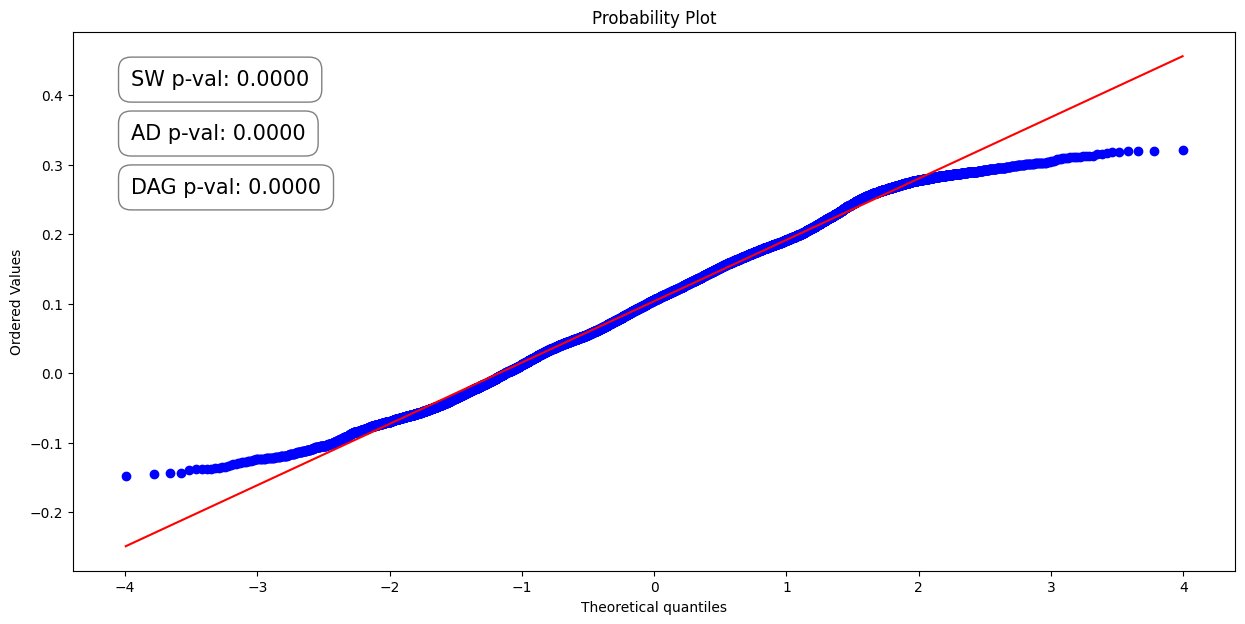

In [28]:
# Checking the normal distribution of residuals
# Required to compute the confidence intervale. 
# Test are showing residuals are not normally distributed so the condidence interval cannot be determined.
# Fixme during the trainig process, only the last epoch residuals are returned and not the complete set
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad

sw_result = stats.shapiro(residuals)
ad_result = normal_ad(residuals, axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals.reshape(-1,), plot=plt)
ax = plt.gca()
result = sw_result[1]
ax.annotate("SW p-val: {:.4f}".format(result), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
if isinstance(ad_result[1], np.ndarray):
    result = ad_result[1][0]
else:
    result = ad_result[1]
ax.annotate(f"AD p-val: {result:.4f}", xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
result = dag_result[1][0]
ax.annotate(f"DAG p-val: {result:.4f}", xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [53]:
a_week = a_day * 7
real_data = series_dict['scaled_data'].values[-a_week:]
X, y = prepare_time_series_multivariate(real_data, features=selected_features,
                           target_col='avg_queue_time_per_job',
                           past_observations_samples=past_observations_samples,
                           future_sample=future_sample)
X = torch.Tensor(X)
X = X.reshape(X.shape[0], X.shape[2], X.shape[1])

time_axis = series_dict['scaled_data'][-a_week:].index

predictions = model(X)

In [76]:

loss = compute_loss(criterion, labels=torch.Tensor(y), model_outputs=predictions)
loss

tensor(0.0268, grad_fn=<MseLossBackward0>)

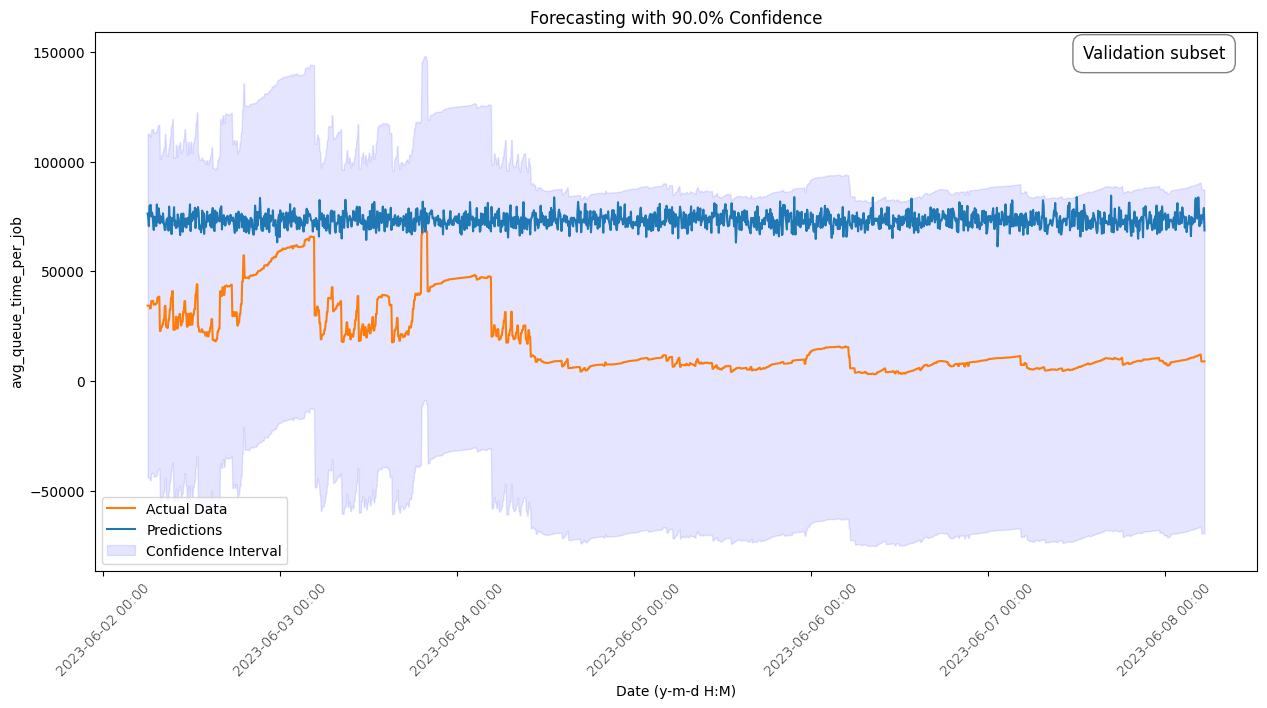

In [71]:
plot_with_ci(y, predictions, 'avg_queue_time_per_job', time_axis, residuals, series_dict['scalers']['avg_queue_time_per_job'], ci=0.90)